# <a id='toc1_'></a>[Computer Vision Applications](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Computer Vision Applications](#toc1_)    
  - [Image classification](#toc1_1_)    
    - [Building a Digit Classifier from Scratch](#toc1_1_1_)    
    - [Using a Pre-trained Model for Advanced Classification](#toc1_1_2_)    
  - [Object Detection](#toc1_2_)    
    - [Object Detection with Faster R-CNN](#toc1_2_1_)    
  - [Image Segmentation](#toc1_3_)    
    - [Image Segmentation with Detectron2](#toc1_3_1_)    
- [Tips](#toc2_)    
  - [Why use PyTorch instead of NumPy to define tensors?](#toc2_1_)    
- [Extra](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [48]:
# This will take a while to run...
!pip install tensorflow keras scikit-image
# !pip install torch torchvision albumentations opencv-python
# !python -m pip install "git+https://github.com/facebookresearch/detectron2.git" 

In [46]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import tensorflow as tf
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from skimage import filters
import time
import os

Check to see if you have a GPU available:

In [ ]:
print(torch.cuda.is_available()) # If False, you don't have a GPU available

The cell below is for Google Colab, where you can get a GPU for faster computation. You likely don't have a dedicated GPU on your computer, unless you're a gamer:

In [ ]:
!nvcc --version

This library (`nvcc`) is specifically for an NVIDIA GPU so the output message would look like this if you had one:

```
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
```

To understand the difference between a CPU and a GPU, here's a [video for you](https://www.youtube.com/watch?v=-P28LKWTzrI).

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image).unsqueeze(0)

## <a id='toc1_1_'></a>[Image classification](#toc0_)

Image classification is the task of assigning a label to an image from a predefined set of categories.

### <a id='toc1_1_1_'></a>[Building a Digit Classifier from Scratch](#toc0_)

Let's build a simple Convolutional Neural Network (CNN) to classify handwritten digits using the MNIST dataset:

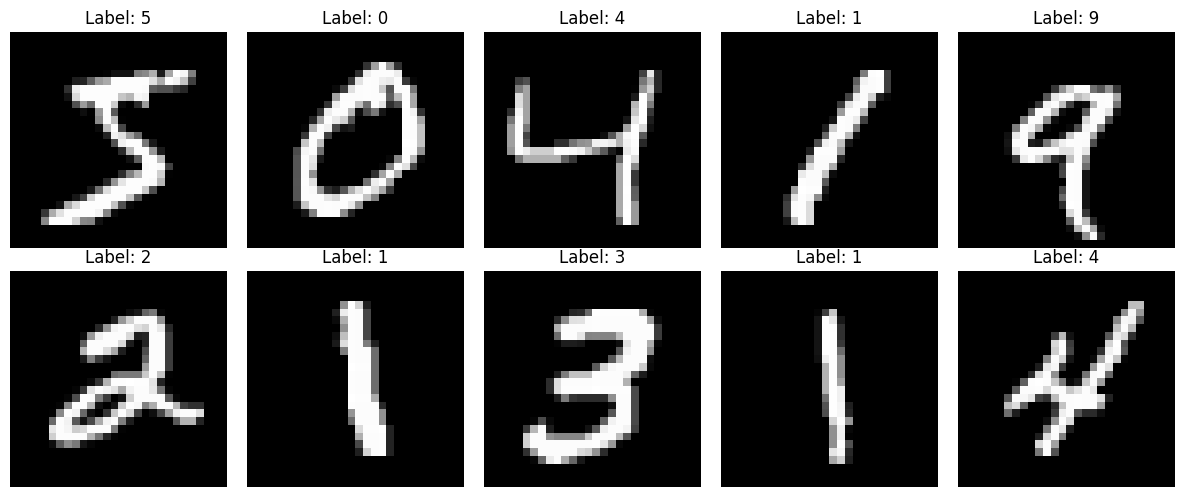

In [49]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize and reshape
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255

# Display some examples
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
y_train # labels are between 0 and 9

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [52]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [53]:
# Build a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print model summary
model.summary()

c:\Users\SabinaFirtala\anaconda3\envs\cv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=5, 
                    validation_split=0.1,
                    verbose=1)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.7943 - loss: 0.6504 - val_accuracy: 0.9818 - val_loss: 0.0602
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9674 - loss: 0.1087 - val_accuracy: 0.9863 - val_loss: 0.0481
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9758 - loss: 0.0799 - val_accuracy: 0.9862 - val_loss: 0.0458
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9809 - loss: 0.0651 - val_accuracy: 0.9905 - val_loss: 0.0348
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9850 - loss: 0.0492 - val_accuracy: 0.9910 - val_loss: 0.0309
Test loss: 0.030078232288360596
Test accuracy: 0.9904000163078308


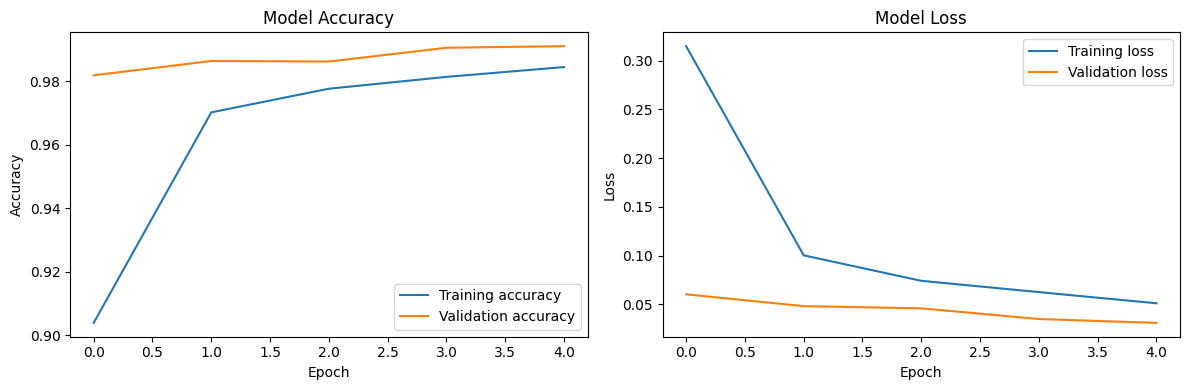

In [55]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


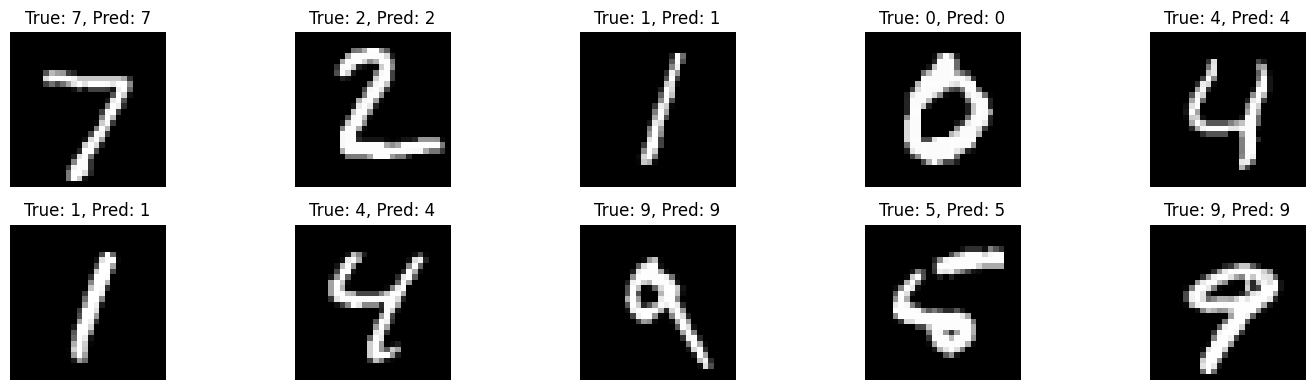

In [56]:
# Make predictions and visualize results
predictions = model.predict(X_test[:10])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[:10], axis=1)

plt.figure(figsize=(15, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {true_classes[i]}, Pred: {predicted_classes[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### <a id='toc1_1_2_'></a>[Using a Pre-trained Model for Advanced Classification](#toc0_)

Now, let's use a pre-trained model for a more complex classification task:

In [57]:
# Load pre-trained ResNet50 model
model = tf.keras.applications.ResNet50(weights='imagenet')

# Function to preprocess and predict
def predict_image(image_path):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Make prediction
    predictions = model.predict(img_array)
    decoded_predictions = tf.keras.applications.resnet50.decode_predictions(predictions, top=5)[0]
    
    # Display image and predictions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    y_pos = np.arange(5)
    plt.barh(y_pos, [pred[2] for pred in decoded_predictions])
    plt.yticks(y_pos, [pred[1] for pred in decoded_predictions])
    plt.xlabel('Probability')
    plt.title('Top 5 Predictions')
    
    plt.tight_layout()
    plt.show()
    
    return decoded_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


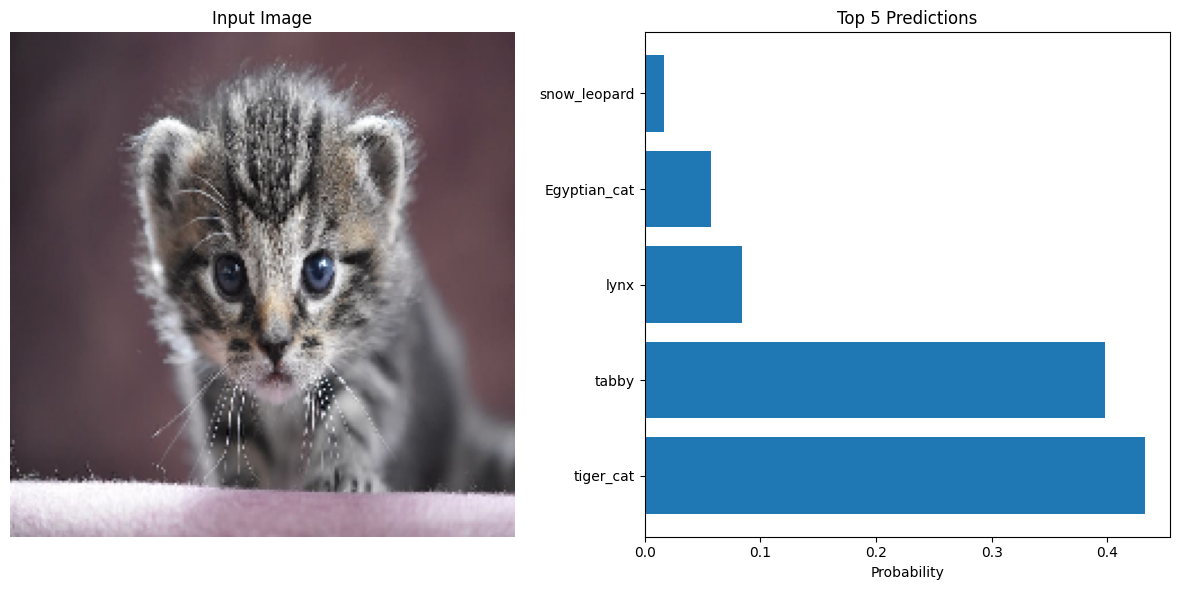

Top predictions:
1: tiger_cat (0.43)
2: tabby (0.40)
3: lynx (0.08)
4: Egyptian_cat (0.06)
5: snow_leopard (0.02)


In [58]:
# Example usage (replace with your own image path)
predictions = predict_image('../../../../img/computer-vision/classification/cats/cat_2.jpg')
print("Top predictions:")
for i, (imagenet_id, label, score) in enumerate(predictions):
    print(f"{i+1}: {label} ({score:.2f})")

ResNet50 is a deep CNN that's been pre-trained on millions of images. It can recognize thousands of different object categories.

## <a id='toc1_2_'></a>[Object Detection](#toc0_)
Object detection is a computer vision technique that identifies and localizes objects within an image. Unlike image classification, which assigns a single label to an image, object detection provides bounding boxes around detected objects. Common object detection models include YOLO (You Only Look Once), SSD (Single Shot MultiBox Detector), and Faster R-CNN.

### <a id='toc1_2_1_'></a>[Object Detection with Faster R-CNN](#toc0_)

In [ ]:
def object_detection(image_path):
    """Performs object detection on an image using Faster R-CNN."""
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    
    image_tensor = load_image(image_path)
    with torch.no_grad():
        prediction = model(image_tensor)
    
    # Display the image with bounding boxes
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for i, box in enumerate(prediction[0]['boxes']):
        x1, y1, x2, y2 = map(int, box.numpy())
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
object_detection("../../../../img/computer-vision/object-detection/image_1.jpg")

## <a id='toc1_3_'></a>[Image Segmentation](#toc0_)
Image segmentation is the process of partitioning an image into multiple regions to identify objects more precisely at the pixel level. There are two main types:
- **Semantic Segmentation**: Classifies each pixel in an image into a category (e.g., sky, car, road).
- **Instance Segmentation**: Distinguishes between individual objects of the same class (e.g., two different cars in an image). Models like U-Net and Mask R-CNN are commonly used for segmentation.

### <a id='toc1_3_1_'></a>[Image Segmentation with Detectron2](#toc0_)

> Detectron2 is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. It is the successor of Detectron and maskrcnn-benchmark. It supports a number of computer vision research projects and production applications in Facebook. *(Source: [Facebook GitHub](https://github.com/facebookresearch/detectron2))*

![](../../../../img/detectron2.png)  
(Source: [Facebook GitHub](https://github.com/facebookresearch/detectron2))

In [ ]:
def image_segmentation(image_path):
    """Performs instance segmentation on an image using Detectron2's Mask R-CNN."""
    cfg = get_cfg()
    cfg.MODEL.DEVICE = "cpu" # Comment this out if you have a GPU
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    predictor = DefaultPredictor(cfg)
    
    image = cv2.imread(image_path)
    outputs = predictor(image)
    
    # Display segmented mask
    v = outputs['instances'].pred_masks.cpu().numpy()
    plt.imshow(v[0], cmap='gray')
    plt.axis("off")
    plt.show()

In [ ]:
image_segmentation("../../../../img/computer-vision/object-detection/image_1.jpg")

# <a id='toc2_'></a>[Tips](#toc0_)

* Using typical architectures is the industry standard -> to figure out your own, academia is probably a better place for you
* Pre-trained models are your best bet at a useful models -> will save you from general edge, color, and feature extraction
* Whenever you see CUDA, it's just the equivalent of C (low-level programming language, known for speed) on the GPU

## <a id='toc2_1_'></a>[Why use PyTorch instead of NumPy to define tensors?](#toc0_)

> [NumPy](https://numpy.org/) is the most widely used library for scientific and numeric programming in Python. It provides very similar functionality and a very similar API to that provided by PyTorch; however, **it does not support using the GPU or calculating gradients, which are both critical for deep learning**. 

# <a id='toc3_'></a>[Extra](#toc0_)

["Visualizing and Understanding Convolutional Networks"](https://arxiv.org/pdf/1311.2901.pdf)